## Setup
### Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os
import sys
from datetime import datetime, timedelta

# Set up matplotlib for nicer plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Add parent directory to path for imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
# Import data utilities
from utils.data_utils import fetch_data, preprocess_data, resample_data, get_risk_free_rate

# Import indicator utilities
from utils.indicator_utils import calculate_kdj, calculate_sma, calculate_macd, calculate_rsi

# Import performance utilities
from utils.performance_utils import (
    calculate_returns, plot_cumulative_returns, 
    plot_rolling_metrics, plot_drawdowns, generate_performance_report
)

# Import strategy
from strategies.kdj_strategy import KDJStrategy

# Import backtesting engine
from backtest.engine import BacktestEngine

# Import optimization module
from optimize.grid_search import GridSearch

### Configure Parameters

In [6]:
# Configuration
ticker = ''           # Ticker symbol
benchmark = 'SPY'         # Benchmark ticker
period = '4y'            # Data period (e.g., '1y', '5y', '10y')
initial_capital = 100000  # Initial capital for backtesting
#start_date = datetime.now()         # Start date for backtesting
#end_date = datetime.now()           # End date for backtesting

# Strategy parameters
strategy_params = {
    'k_period': 9,           
    'j_buy_threshold': -5,   
    'j_sell_threshold': 100,  
    'daily_enabled': True,   
    'weekly_enabled': True,  
    'monthly_enabled': False,
    'position_size': 0.7     
}

### Download and Preprocess Data

In [7]:
# Fetch data

print(f"Fetching data for {ticker} with {benchmark} as benchmark...")
data = fetch_data(ticker, period=period, benchmark=benchmark)


Fetching data for 0700.HK with SPY as benchmark...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Original columns: [('Close', '0700.HK'), ('High', '0700.HK'), ('Low', '0700.HK'), ('Open', '0700.HK'), ('Volume', '0700.HK')]
Fixed columns: ['close', 'high', 'low', 'open', 'volume']
                 close        high         low        open    volume
Date                                                                
2021-03-15  565.432434  587.941723  559.129836  585.240558  37980809
2021-03-16  567.683350  579.388158  562.731333  575.336531  21200125
2021-03-17  562.281128  575.336519  560.030217  562.281128  20718031
2021-03-18  576.687012  586.591103  569.033891  571.734996  24258336
2021-03-19  565.432434  574.886332  561.830941  565.432434  24450964


[*********************100%***********************]  1 of 1 completed

Original benchmark columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Fixed benchmark columns: ['close', 'high', 'low', 'open', 'volume']
                 close        high         low        open     volume
Date                                                                 
2021-03-15  374.384796  374.649238  370.248152  372.420348   73427200
2021-03-16  373.912537  375.725842  373.128637  375.008088   73722500
2021-03-17  375.187592  375.999795  371.447595  372.609264   97959300
2021-03-18  369.728729  374.677577  369.039279  372.562044  115349100
2021-03-19  369.044647  371.024985  366.836882  369.423654  113624500


In [8]:
print(data.head())

            0700.HK_close  0700.HK_high  0700.HK_low  0700.HK_open  \
Date                                                                 
2021-03-15     565.432434    587.941723   559.129836    585.240558   
2021-03-16     567.683350    579.388158   562.731333    575.336531   
2021-03-17     562.281128    575.336519   560.030217    562.281128   
2021-03-18     576.687012    586.591103   569.033891    571.734996   
2021-03-19     565.432434    574.886332   561.830941    565.432434   

            0700.HK_volume   SPY_close    SPY_high     SPY_low    SPY_open  \
Date                                                                         
2021-03-15        37980809  374.384796  374.649238  370.248152  372.420348   
2021-03-16        21200125  373.912537  375.725842  373.128637  375.008088   
2021-03-17        20718031  375.187592  375.999795  371.447595  372.609264   
2021-03-18        24258336  369.728729  374.677577  369.039279  372.562044   
2021-03-19        24450964  369.044647  3

In [48]:


# Preprocess data
data = preprocess_data(data, ticker)

# Display first few rows
print(data.head())

            LKNCY_close  LKNCY_high  LKNCY_low  LKNCY_open  LKNCY_volume  \
Date                                                                       
2021-03-16         8.72       9.450       7.71        7.72      13388700   
2021-03-17         8.81       8.888       8.06        8.40       4337800   
2021-03-18         9.01       9.300       8.81        8.90       3090700   
2021-03-19         9.99      10.500       9.20        9.37       4973300   
2021-03-22        11.24      11.250       9.90        9.94       4586900   

             SPY_close    SPY_high     SPY_low    SPY_open  SPY_volume  \
Date                                                                     
2021-03-16  373.912598  375.725903  373.128698  375.008150    73722500   
2021-03-17  375.187622  375.999825  371.447625  372.609295    97959300   
2021-03-18  369.728699  374.677546  369.039248  372.562013   115349100   
2021-03-19  369.044617  371.024954  366.836852  369.423624   113624500   
2021-03-22  371.991425 

/Users/haiyangyu/Library/CloudStorage/OneDrive-KekeChen/Haiyangyu/UCLA MFE/fintech/trading_strategy_project/utils/data_utils.py:145: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## Strategy Implementation

In [49]:
# Create strategy instance
strategy = KDJStrategy(ticker, strategy_params)

# Prepare data for the strategy
prepared_data = strategy.prepare_data(data)

# Generate trading signals
signals_data = strategy.generate_signals(prepared_data)

# Display generated signals
signals_data[[f'{ticker}_close', f'{ticker}_kdj_j_weighted', f'{ticker}_signal', f'{ticker}_position_size']].tail(10)

,LKNCY_close,LKNCY_kdj_j_weighted,LKNCY_signal,LKNCY_position_size
Date,,,,
2025-02-27,29.950001,67.628938,0,0.0
2025-02-28,29.750000,66.557805,0,0.0
2025-03-03,27.610001,52.214362,0,0.0
2025-03-04,28.969999,51.105510,0,0.0
2025-03-05,29.570000,49.756733,0,0.0
2025-03-06,28.830000,50.887561,0,0.0
2025-03-07,29.980000,53.872955,0,0.0
2025-03-10,28.040001,39.349330,0,0.0
2025-03-11,30.930000,53.207174,0,0.0


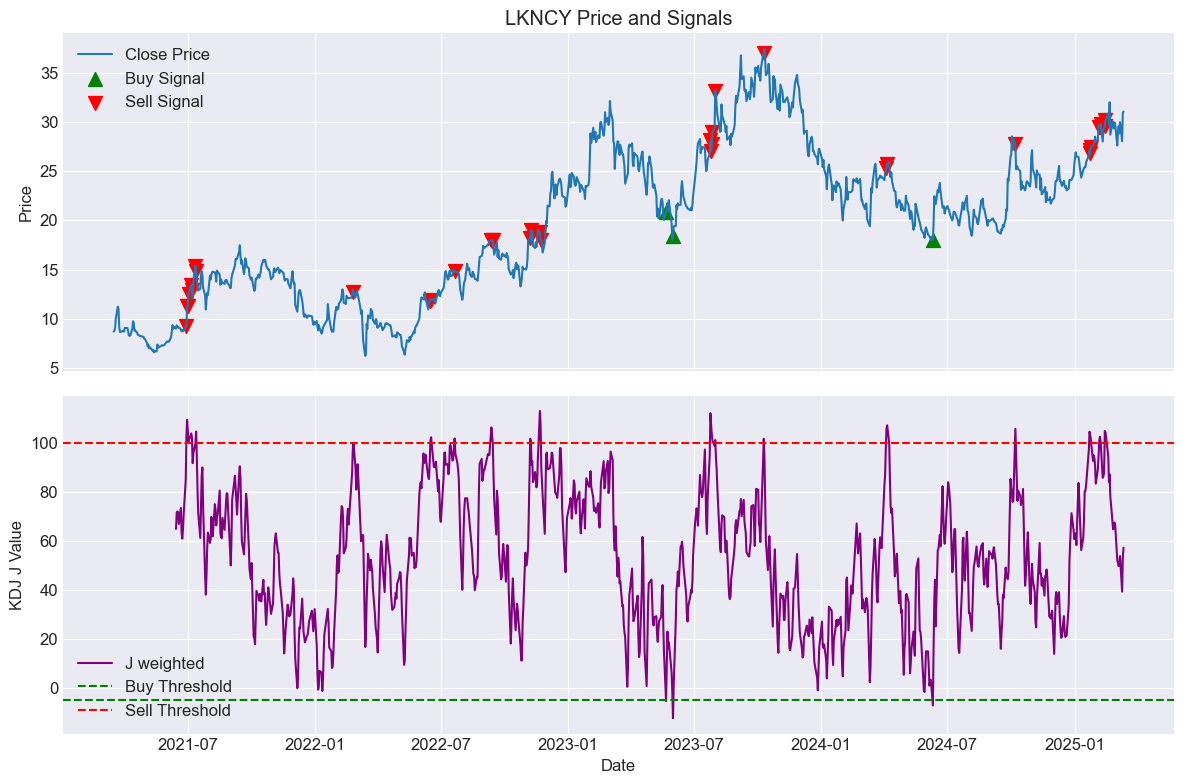

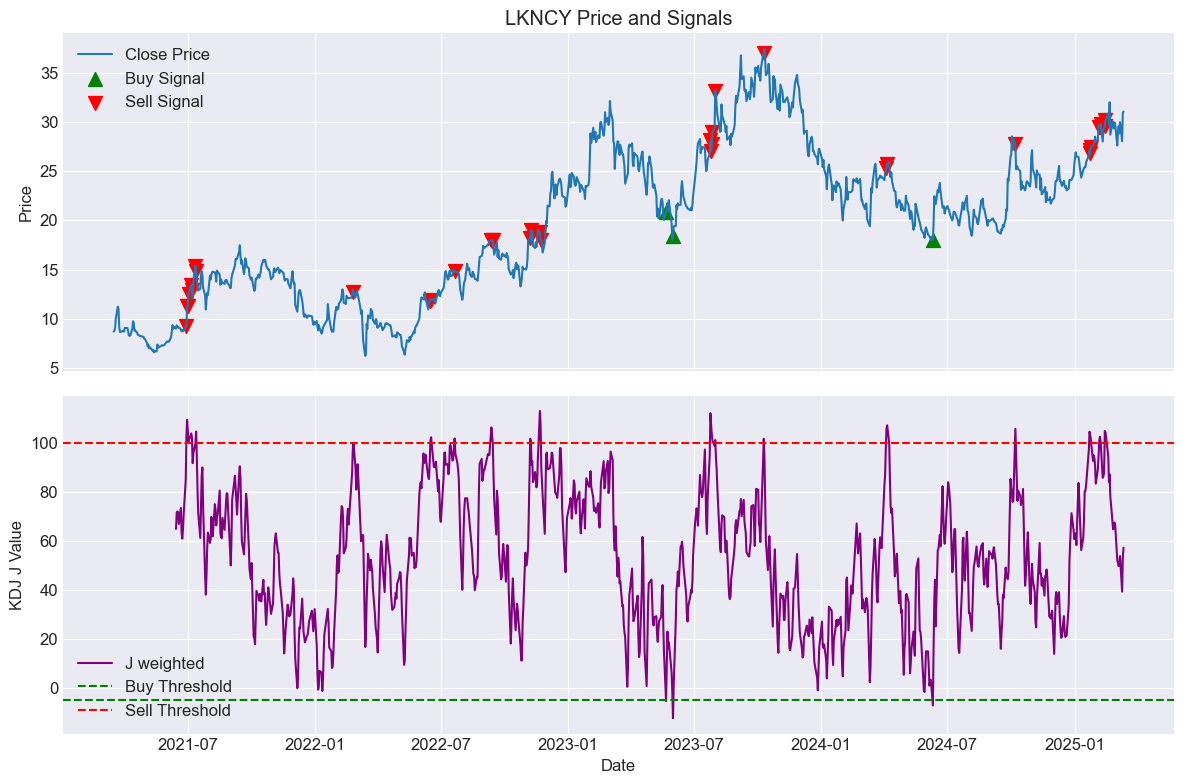

In [50]:
# Define function to plot KDJ indicator with signals
def plot_kdj_signals(df, ticker, start_date=None, end_date=None, figsize=(12, 8), strategy_params=strategy_params):
    if start_date:
        df = df.loc[start_date:]
    if end_date:
        df = df.loc[:end_date]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot price with buy/sell signals
    ax1.plot(df.index, df[f'{ticker}_close'], label='Close Price')
    buy_signals = df[df[f'{ticker}_signal'] == 1]
    sell_signals = df[df[f'{ticker}_signal'] == -1]

    ax1.scatter(buy_signals.index, buy_signals[f'{ticker}_close'], color='green', marker='^', s=100, label='Buy Signal')
    ax1.scatter(sell_signals.index, sell_signals[f'{ticker}_close'], color='red', marker='v', s=100, label='Sell Signal')

    ax1.set_title(f'{ticker} Price and Signals')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Plot KDJ J line with thresholds
    ax2.plot(df.index, df[f'{ticker}_kdj_j_weighted'], label='J weighted', color='purple')
    ax2.axhline(y=strategy_params['j_buy_threshold'], color='green', linestyle='--', label='Buy Threshold')
    ax2.axhline(y=strategy_params['j_sell_threshold'], color='red', linestyle='--', label='Sell Threshold')

    ax2.set_ylabel('KDJ J Value')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    return fig

# Plot last 180 days
end_date = signals_data.index[-1]
start_date = signals_data.index[0]
plot_kdj_signals(signals_data, ticker, start_date, end_date)

## Backtesting

In [51]:
# Get start and end dates from our data
start_date = data.index[0]
end_date = data.index[-1]

# Fetch daily risk-free rates for the entire period
print(f"Fetching daily risk-free rates...")
risk_free_rates = get_risk_free_rate(start_date=start_date, end_date=end_date)
print(risk_free_rates.head())

[*********************100%***********************]  1 of 1 completed

Fetching daily risk-free rates...
Date
2021-03-16    0.00008
2021-03-17    0.00008
2021-03-18    0.00003
2021-03-19    0.00005
2021-03-22    0.00005
Name: (Close, ^IRX), dtype: float64



/Users/haiyangyu/Library/CloudStorage/OneDrive-KekeChen/Haiyangyu/UCLA MFE/fintech/trading_strategy_project/utils/data_utils.py:220: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_rf = daily_rf.fillna(method='ffill').fillna(method='bfill')


In [52]:
# Create backtesting engine with daily risk-free rates
engine = BacktestEngine(initial_capital=initial_capital, risk_free_rate=risk_free_rates)

# Run backtest
print(f"Running backtest for {ticker} with strategy {strategy.name}...")
backtest_results = engine.run(data, ticker, strategy)

# Display backtest results
print(backtest_results[[f'{ticker}_position', f'{ticker}_cash', f'{ticker}_equity', f'{ticker}_strategy_return']].tail())

Running backtest for LKNCY with strategy KDJ Strategy...
            LKNCY_position     LKNCY_cash   LKNCY_equity  \
Date                                                       
2025-03-06     1777.076996  125495.606785  176728.736440   
2025-03-07     1777.076996  125516.507779  178793.275302   
2025-03-10     1777.076996  125537.352485  175366.593076   
2025-03-11     1777.076996  125558.250469  180523.242494   
2025-03-12     1777.076996  125579.151933  180757.391299   

            LKNCY_strategy_return  
Date                               
2025-03-06              -0.007270  
2025-03-07               0.011682  
2025-03-10              -0.019166  
2025-03-11               0.029405  
2025-03-12               0.001297  


In [53]:
portfolio_trade = engine.get_trades(backtest_results, ticker)

In [54]:
print(portfolio_trade.columns)

Index(['LKNCY_close', 'LKNCY_high', 'LKNCY_low', 'LKNCY_open', 'LKNCY_volume',
       'SPY_close', 'SPY_high', 'SPY_low', 'SPY_open', 'SPY_volume',
       'LKNCY_daily_return', 'LKNCY_log_return', 'LKNCY_kdj_k', 'LKNCY_kdj_d',
       'LKNCY_kdj_j', 'LKNCY_kdj_j_weekly', 'LKNCY_signal',
       'LKNCY_kdj_j_weighted', 'LKNCY_position_size', 'LKNCY_position',
       'LKNCY_equity', 'LKNCY_cash', 'LKNCY_holdings', 'LKNCY_trade',
       'LKNCY_commission', 'LKNCY_slippage', 'LKNCY_strategy_return',
       'LKNCY_cum_return', 'trade_type', 'trade_value'],
      dtype='object')


In [55]:
print(portfolio_trade.iloc[:,-12:])

            LKNCY_position_size  LKNCY_position   LKNCY_equity     LKNCY_cash  \
Date                                                                            
2023-05-22                  0.7     3485.115375  103826.221924   31091.861119   
2023-06-01                  0.7     3620.913791   95434.189986   28628.327775   
2023-07-25                 -0.7     1393.962203  130591.843647   91393.625332   
2023-07-28                 -0.7     1364.232526  131874.862515   92312.119248   
2023-08-01                 -0.7     1244.266278  137611.473067   96326.717588   
2023-10-10                 -0.7     1161.329493  143420.809324  100393.552500   
2024-06-10                  0.7     4843.856350  124829.174032   37397.570612   
2024-10-07                 -0.7     1863.193069  172626.812713  120811.414458   
2025-02-05                 -0.7     1804.982169  177488.024354  124241.050365   
2025-02-07                 -0.7     1793.923281  178016.627527  124611.530625   
2025-02-14                 -

In [56]:
print(backtest_results.columns)

Index(['LKNCY_close', 'LKNCY_high', 'LKNCY_low', 'LKNCY_open', 'LKNCY_volume',
       'SPY_close', 'SPY_high', 'SPY_low', 'SPY_open', 'SPY_volume',
       'LKNCY_daily_return', 'LKNCY_log_return', 'LKNCY_kdj_k', 'LKNCY_kdj_d',
       'LKNCY_kdj_j', 'LKNCY_kdj_j_weekly', 'LKNCY_signal',
       'LKNCY_kdj_j_weighted', 'LKNCY_position_size', 'LKNCY_position',
       'LKNCY_equity', 'LKNCY_cash', 'LKNCY_holdings', 'LKNCY_trade',
       'LKNCY_commission', 'LKNCY_slippage', 'LKNCY_strategy_return',
       'LKNCY_cum_return'],
      dtype='object')


## Performance Analysis

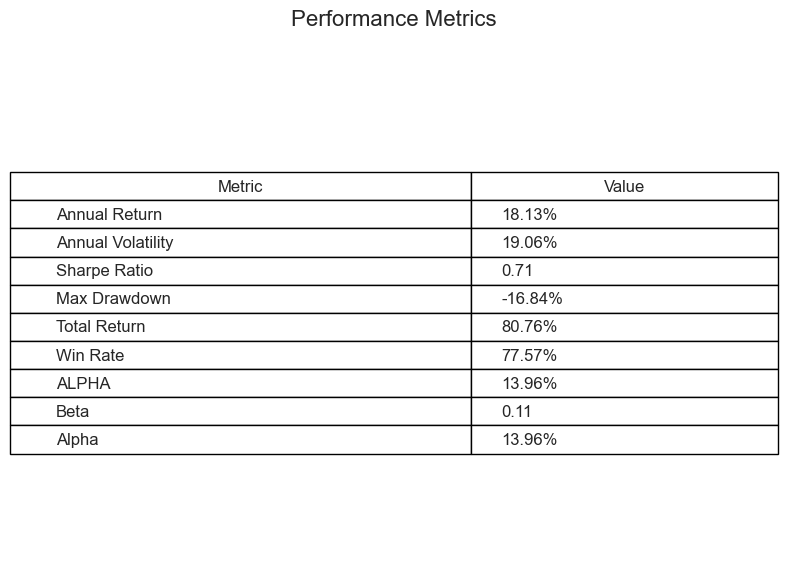

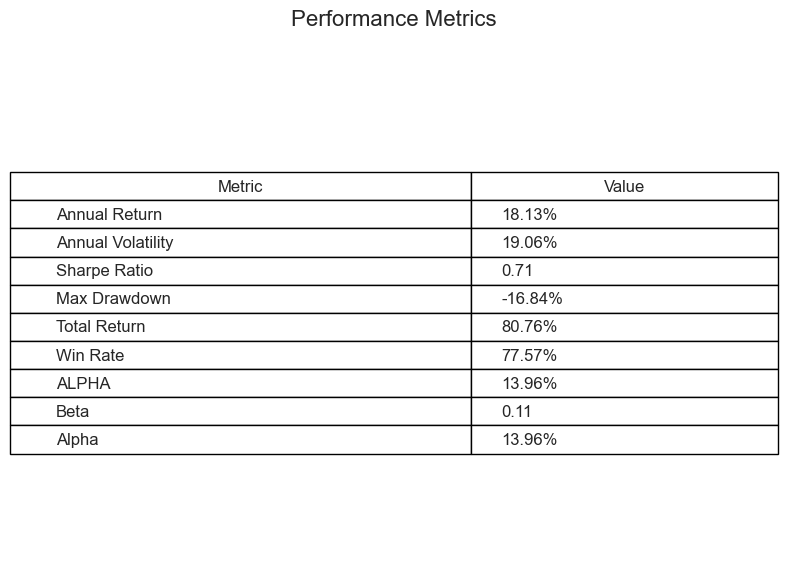

In [57]:
# Calculate performance metrics using daily risk-free rates
metrics = calculate_returns(backtest_results, ticker, benchmark, risk_free_rates)

# Generate performance report
generate_performance_report(metrics)

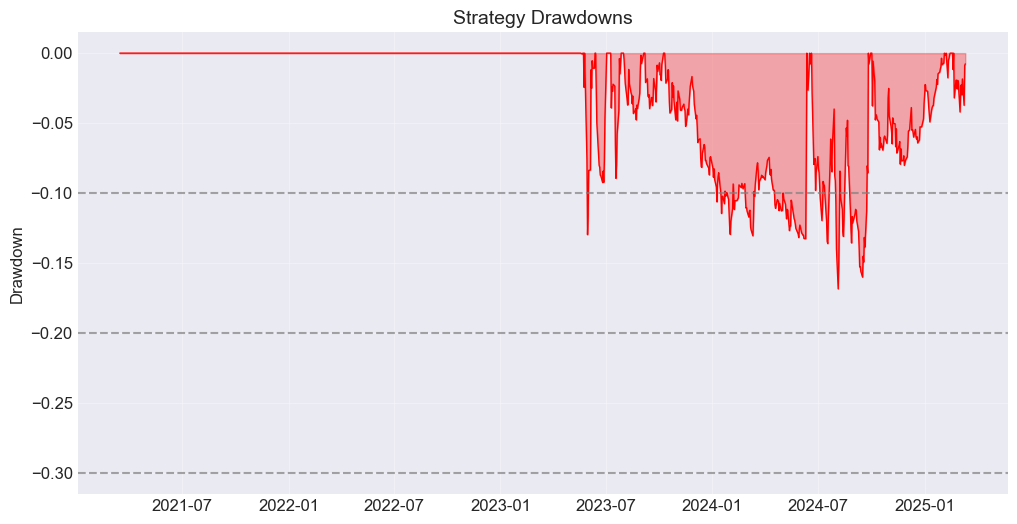

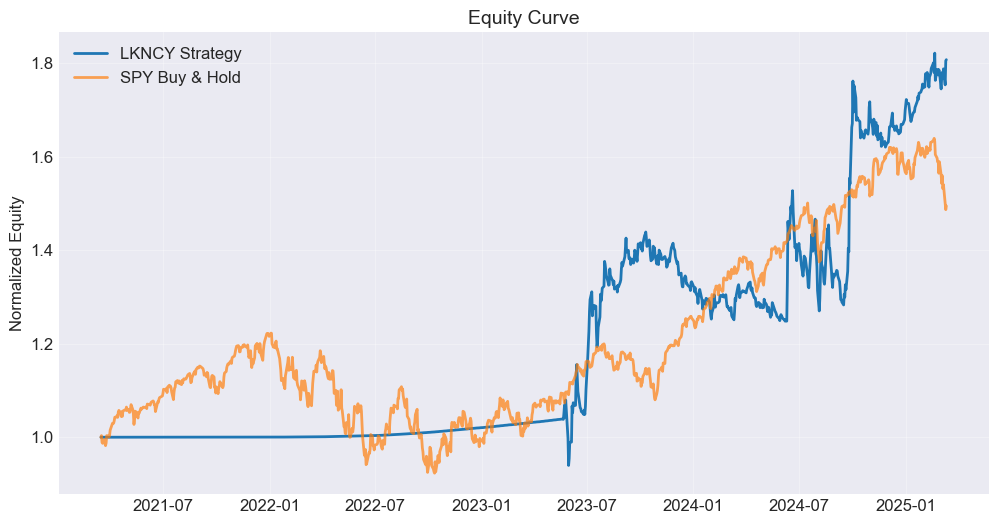

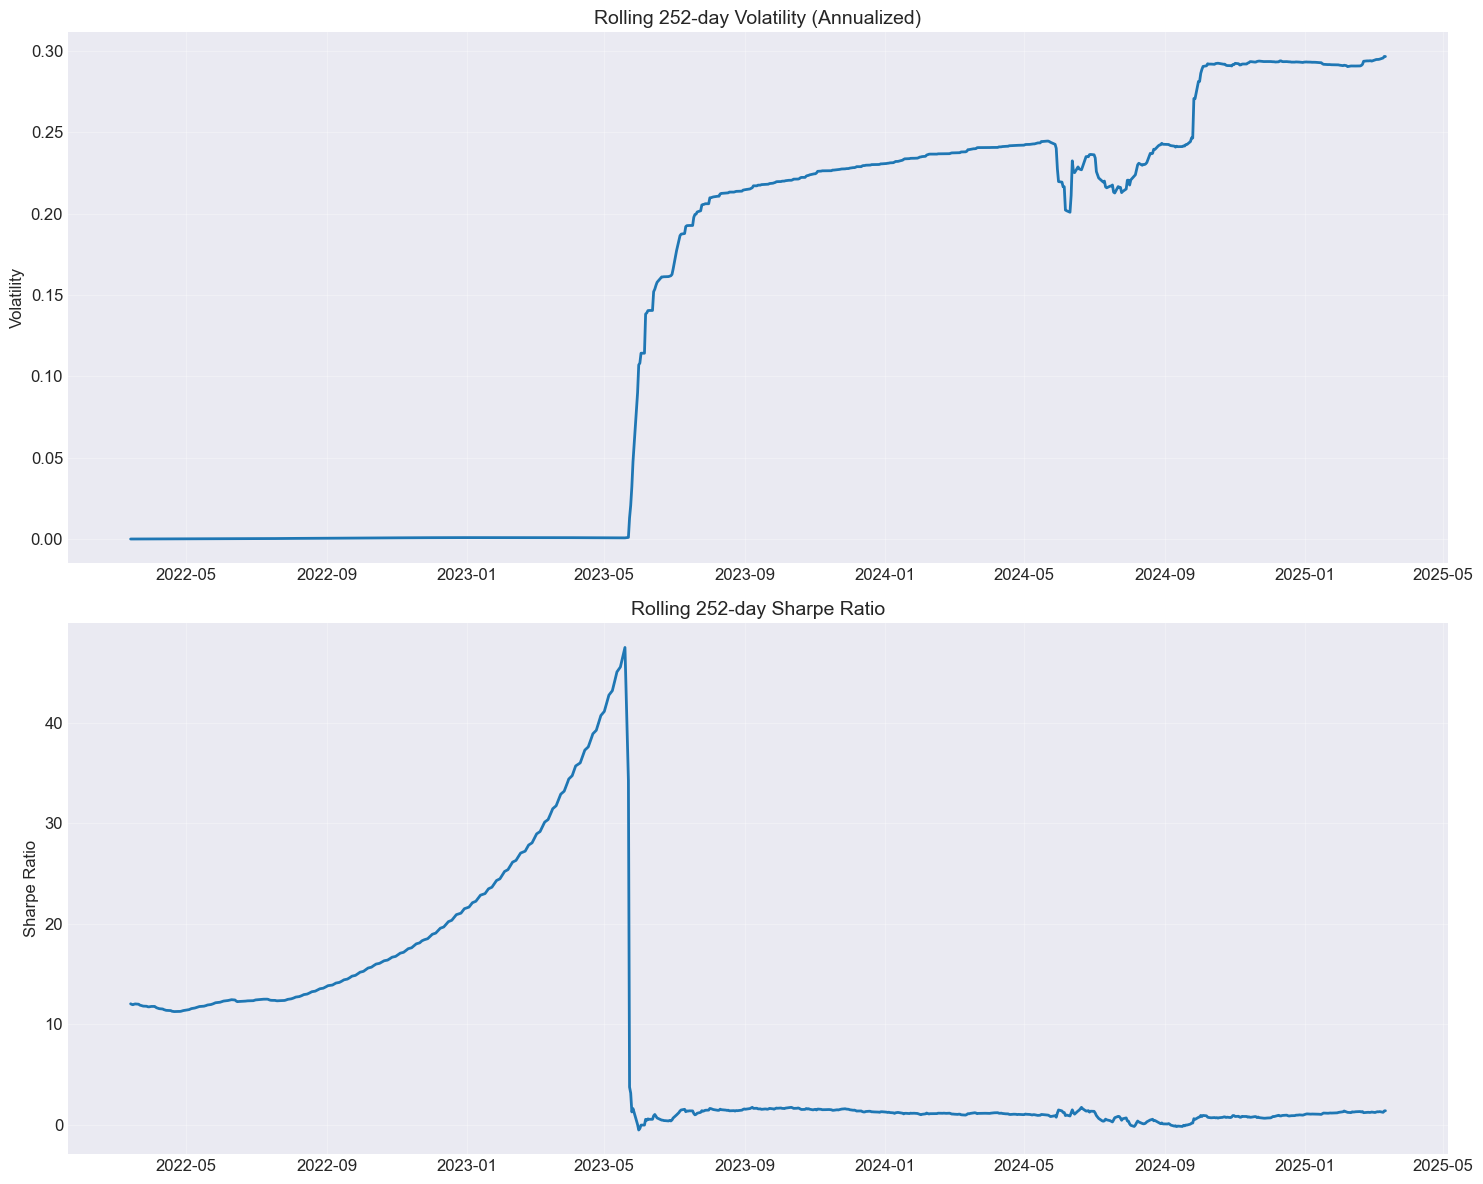

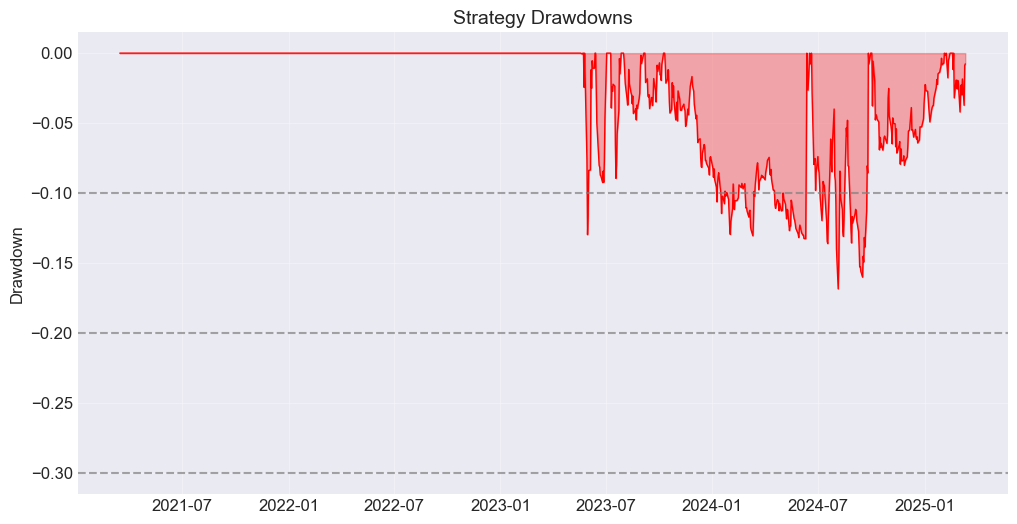

In [58]:
engine.plot_equity_curve(backtest_results, ticker, benchmark)
plot_rolling_metrics(backtest_results, ticker)
engine.plot_drawdowns(backtest_results, ticker)

## Optimization

In [59]:
# Define parameter grid
param_grid = {
    'k_period': [9],
    'j_buy_threshold': [-5, 0,5],
    'j_sell_threshold': [  100, 105, 110],
    'daily_enabled': [True],
    'weekly_enabled': [True],
    'position_size': [ 0.5,  0.7, 1.0],
    'weekly_weight': [ 0.5, 0.75, 1.0],
}

# Create and run grid search
grid_search = GridSearch(
    data=data,
    ticker=ticker,
    strategy_class=KDJStrategy,
    param_grid=param_grid,
    metric='sharpe_ratio',
    maximize=True,
    n_jobs=1  
)
grid_search.fit()

Grid search with 81 parameter combinations
Progress: 8/81 combinations evaluated (4.32s)
Progress: 16/81 combinations evaluated (8.56s)
Progress: 24/81 combinations evaluated (12.82s)
Progress: 32/81 combinations evaluated (17.16s)
Progress: 40/81 combinations evaluated (21.35s)
Progress: 48/81 combinations evaluated (25.69s)
Progress: 56/81 combinations evaluated (29.94s)
Progress: 64/81 combinations evaluated (34.27s)
Progress: 72/81 combinations evaluated (38.55s)
Progress: 80/81 combinations evaluated (42.81s)

Grid search completed in 43.37s
Best sharpe_ratio: 1.0659
Best parameters: {'k_period': 9, 'j_buy_threshold': -5, 'j_sell_threshold': 100, 'daily_enabled': True, 'weekly_enabled': True, 'position_size': 1.0, 'weekly_weight': 0.5}


## Optimization Validation

Best parameters: {'k_period': 9, 'j_buy_threshold': -5, 'j_sell_threshold': 100, 'daily_enabled': True, 'weekly_enabled': True, 'position_size': 1.0, 'weekly_weight': 0.5}


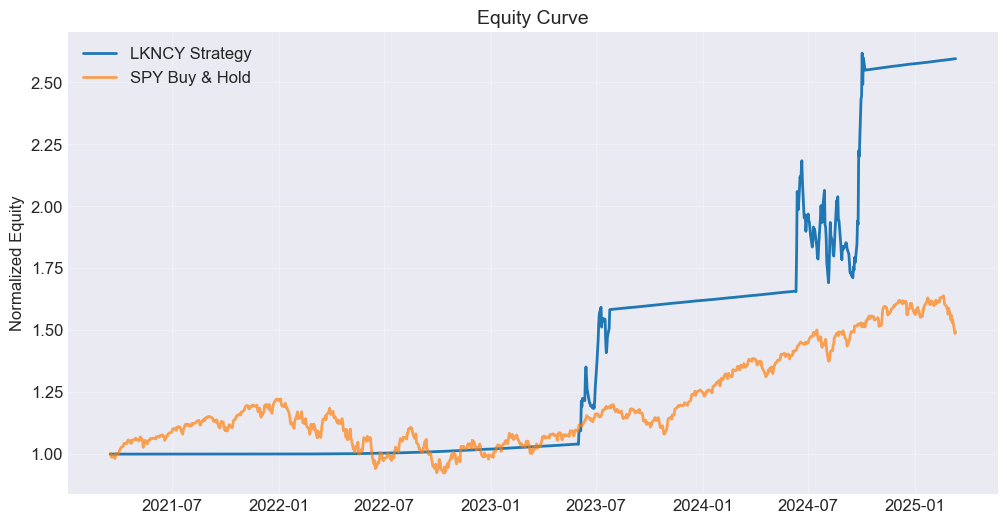

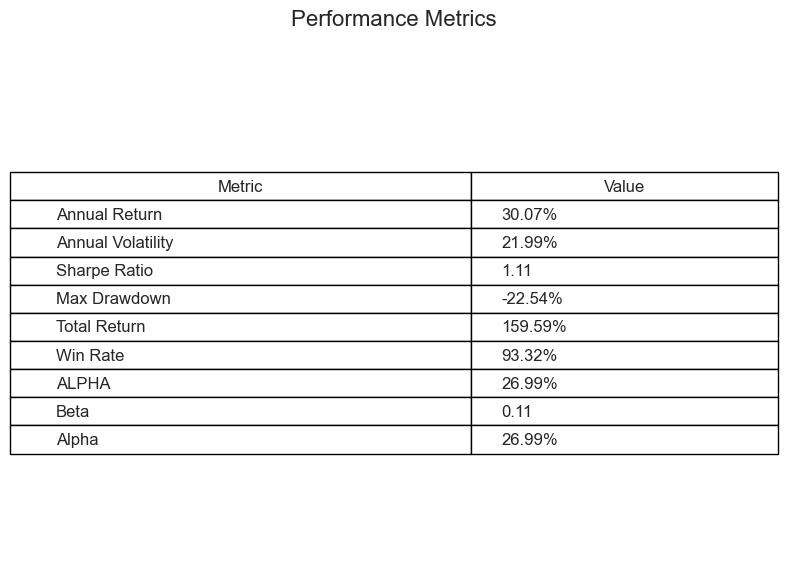

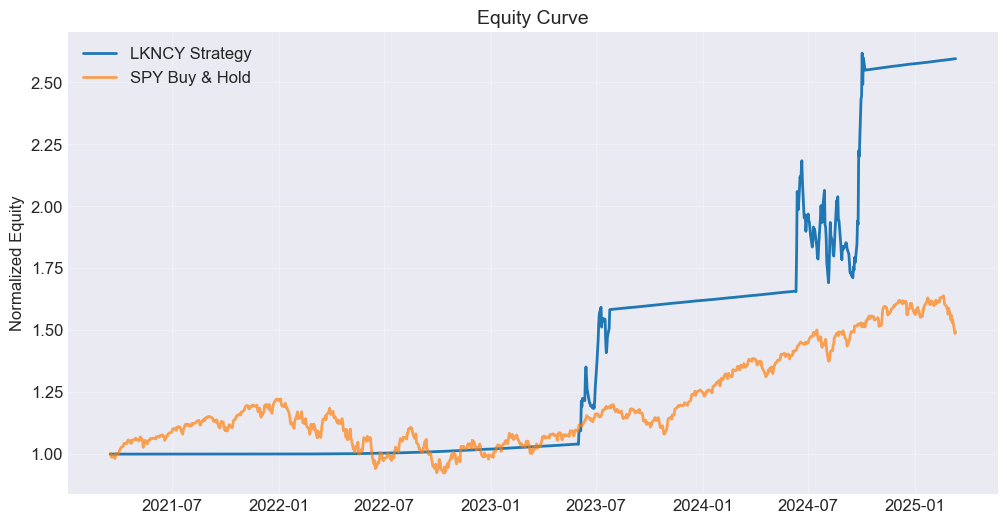

In [60]:
# Apply best parameters
best_strategy = KDJStrategy(ticker, grid_search.best_params)
print(f"Best parameters: {grid_search.best_params}")

# Run final backtest
best_backtest = engine.run(data, ticker, best_strategy)

# Evaluate performance
best_metrics = calculate_returns(best_backtest, ticker, benchmark)
generate_performance_report(best_metrics)

# Plot final equity curve
engine.plot_equity_curve(best_backtest, ticker, benchmark)

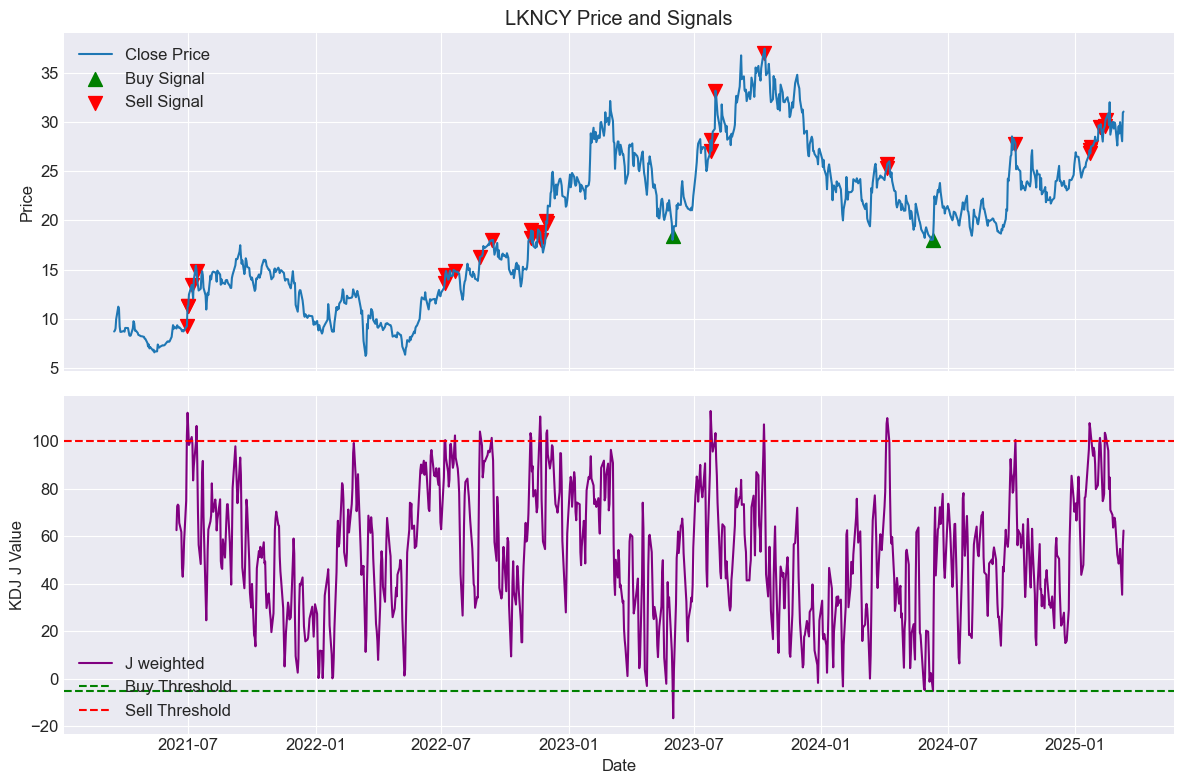

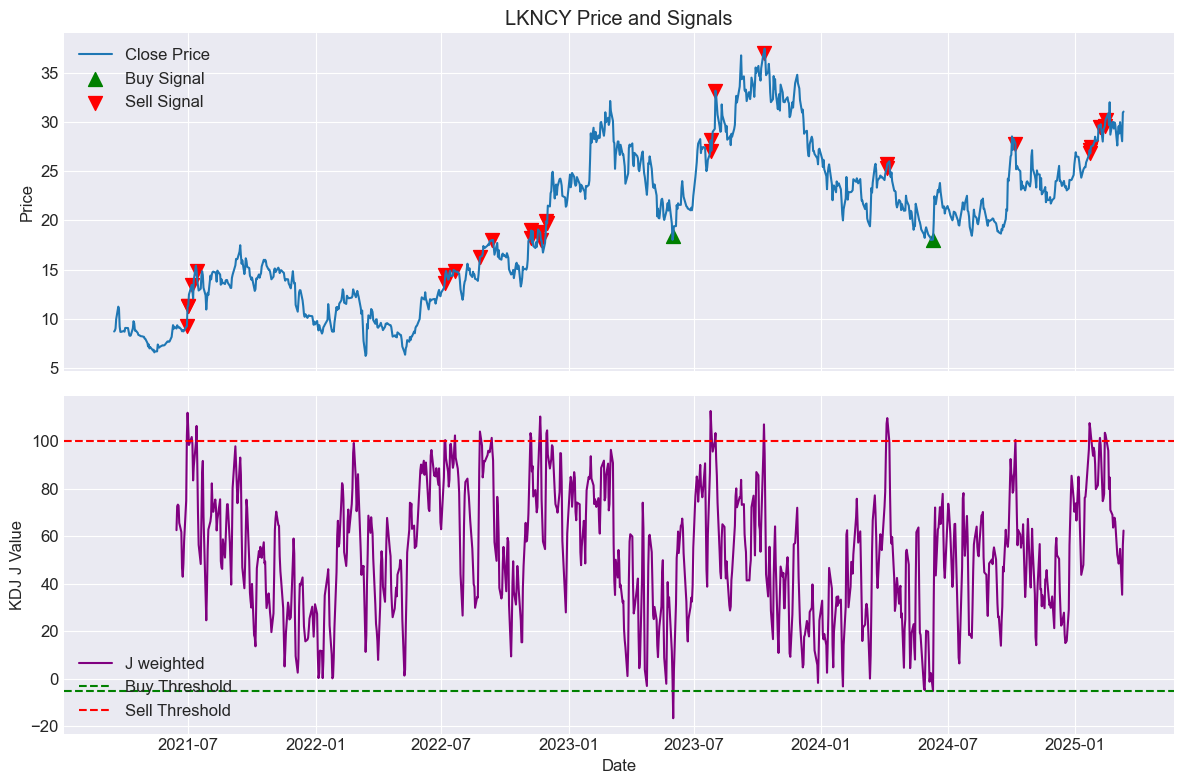

In [61]:
best_signals_data = best_strategy.generate_signals(best_strategy.prepare_data(data))
plot_kdj_signals(best_signals_data, ticker, start_date, end_date, strategy_params=best_strategy.params)

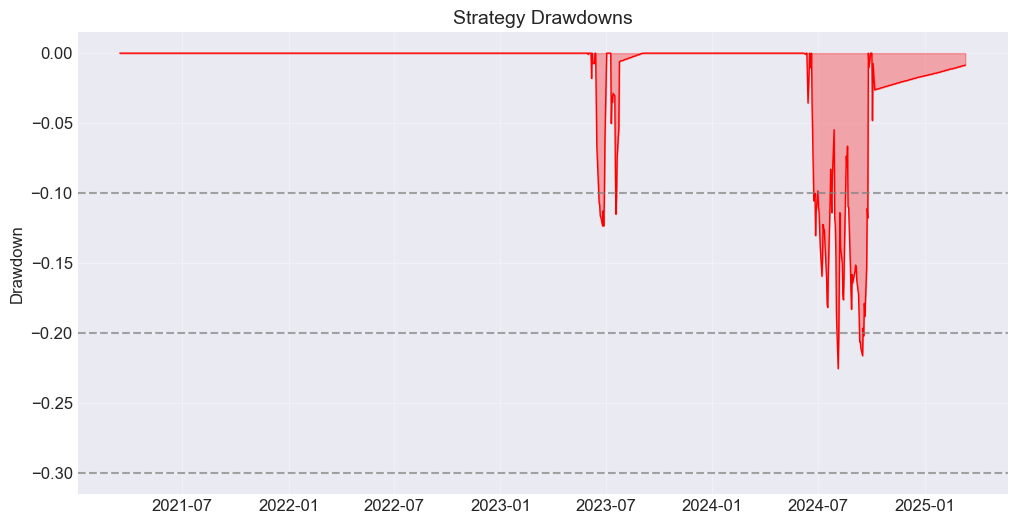

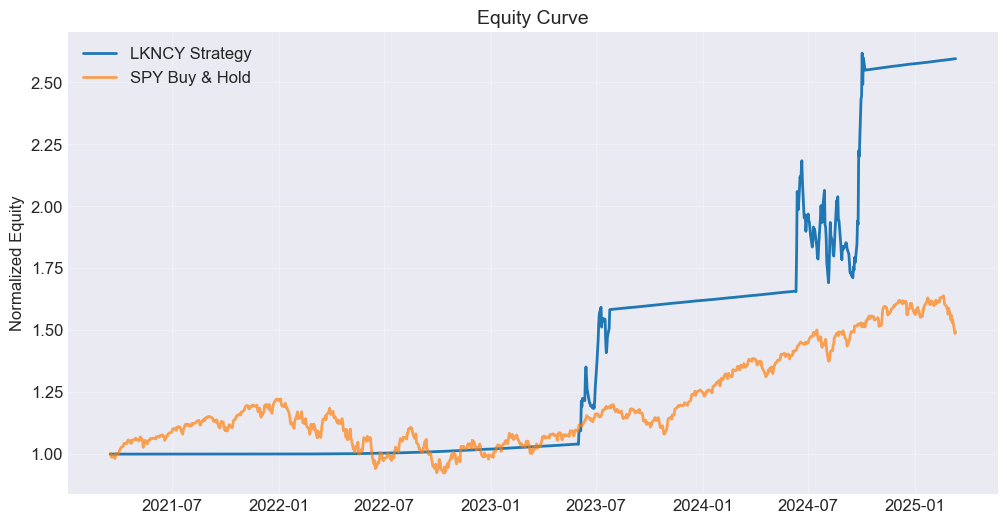

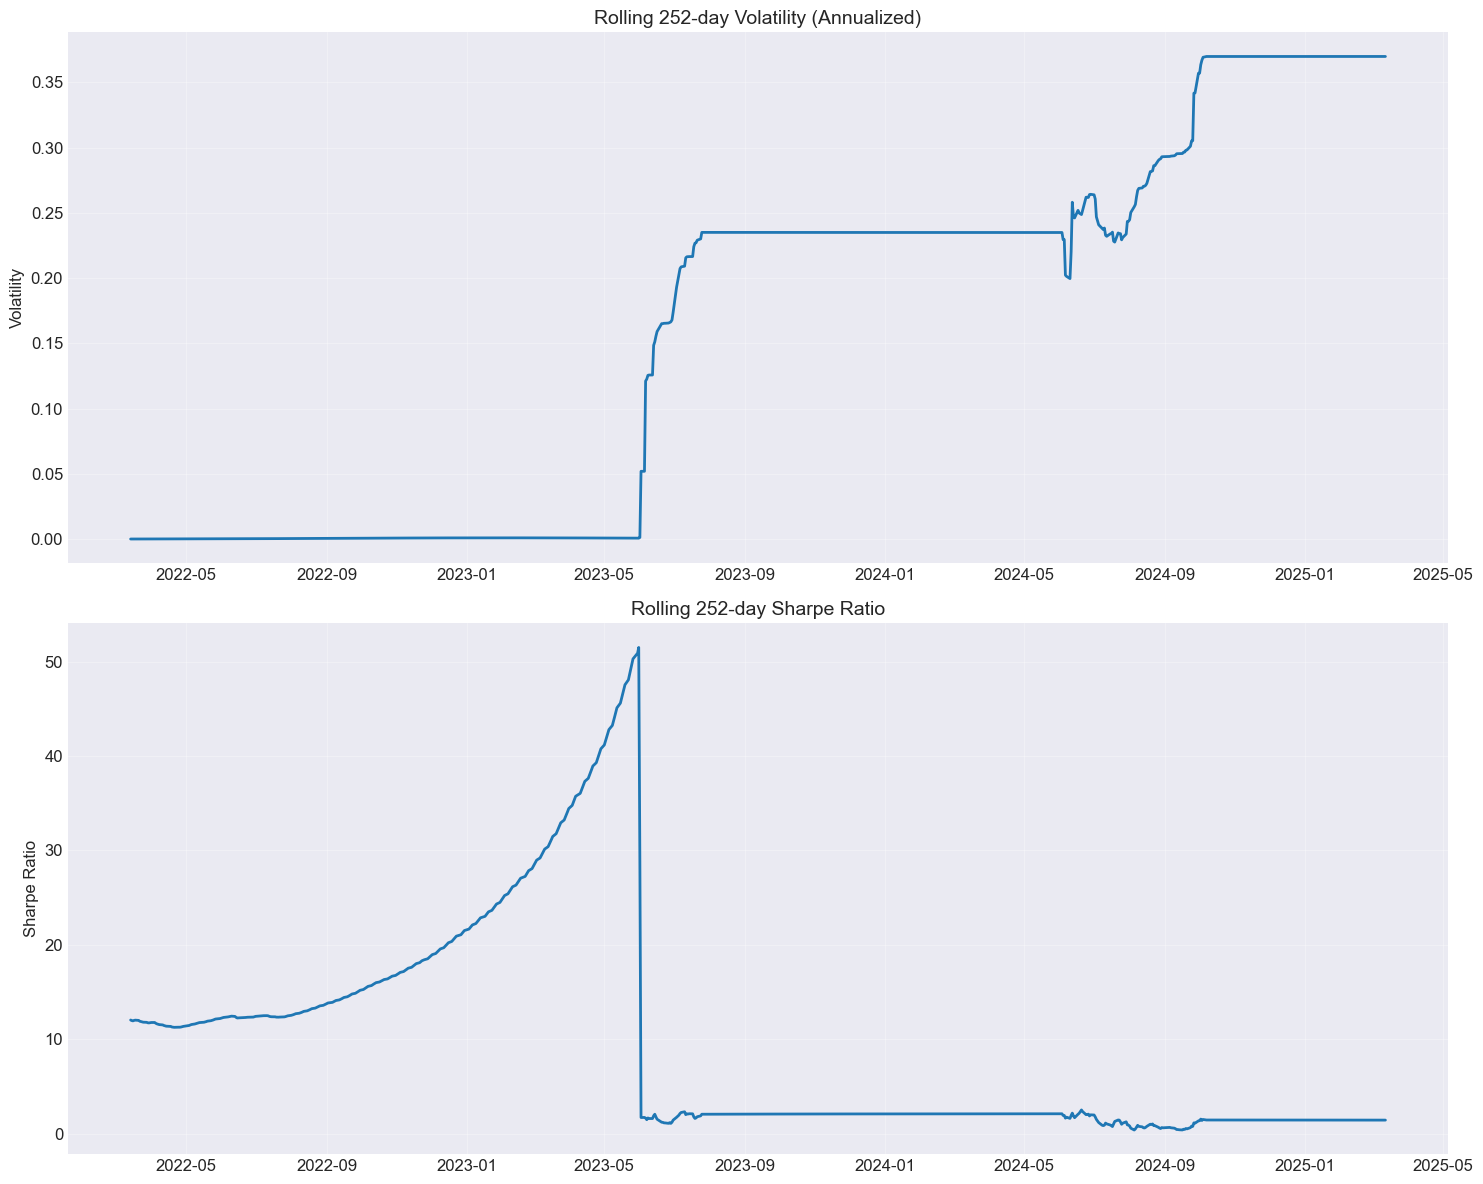

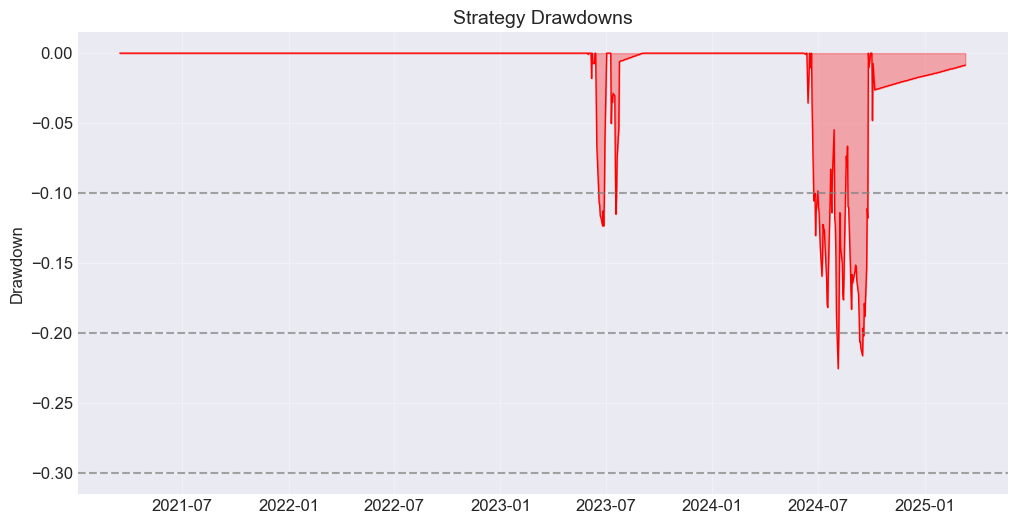

In [62]:
engine.plot_equity_curve(best_backtest, ticker, benchmark)
plot_rolling_metrics(best_backtest, ticker)
engine.plot_drawdowns(best_backtest, ticker)

$$
dG(t,F)
= \underbrace{\frac{\partial G}{\partial t}\,dt}{\text{time part}}
\;+\;\underbrace{\frac{\partial G}{\partial F}\,dF}{\text{linear part in } dF}
\;+\;\underbrace{\tfrac12 \,\frac{\partial^2 G}{\partial F^2}\,(dF)^2}_{\text{second-order term}}
\;+\;\dots
$$